In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

## Part I - Average Filter

In [2]:
def averageFiltering(img,k):
    img = img.astype(np.float64)
    x = img.shape[0]
    y = img.shape[1]
    temp = np.zeros((x+k-1,y+k-1))
    kh = int(k/2)
    temp[kh:kh+x,kh:kh+y] = img[:,:]
    n_img = np.zeros((x,y))
    for i in range(kh,kh+x):
        for j in range(kh,kh+y):
            n_img[i-kh,j-kh] = np.mean(temp[i-kh:i+kh+1,j-kh:j+kh+1])
    return n_img

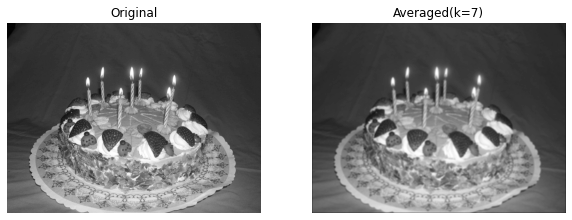

Runtime for unoptimized :  6.897294282913208


In [3]:
cake = cv2.imread("../images/cake_flash.jpg",0)
start = time.time()
res = averageFiltering(cake,7)
end = time.time()

fig=plt.figure(figsize=[10,10])

ax = fig.add_subplot(1,2,1)
ax.set_title('Original')
ax.imshow(cake,cmap='gray')
plt.axis('off')

ax = fig.add_subplot(1,2,2)
ax.set_title('Averaged(k=7)')
ax.imshow(res,cmap='gray')
plt.axis('off')
plt.show()


print("Runtime for unoptimized : ",end-start)


## 1.1 
 -  Implemented a bruteforce algorithm for computing mean in O(n*m*(k^2)) nothing optimisation    done its just kind of convolution but not exactly convolution(here the filters are not flipped)

## Part II - Optimized Average Filter

In [4]:
def efficientAverageFiltering(img,k):
    img = img.astype(np.float64)
    x = img.shape[0]
    y = img.shape[1]
    kh = int(k/2)
    cumx = np.zeros((x,y))
    n_img = np.zeros((x,y))
    for i in range(x):
        if i < kh:
            cumx[i,:] = img[0:i+kh+1,:].sum(axis=0).cumsum()
        elif i > x-kh-1:
            cumx[i,:] = img[i-kh:x,:].sum(axis=0).cumsum()
        else:
            cumx[i,:] = img[i-kh:i+kh+1,:].sum(axis=0).cumsum()
        for j in range(y):
            if j < kh+1:
                n_img[i,j] = cumx[i,j+kh]
            elif j > y-kh-1:
                n_img[i,j] = cumx[i,y-1] - cumx[i,j-kh-1]
            else:
                n_img[i,j] = cumx[i,j+kh] - cumx[i,j-kh-1]
    return n_img/(k*k)

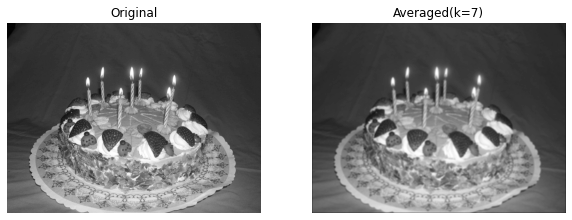

Runtime for Optimized :  0.7039380073547363


In [5]:
start = time.time()
res = efficientAverageFiltering(cake,7)
end = time.time()

fig=plt.figure(figsize=[10,10])

ax = fig.add_subplot(1,2,1)
ax.set_title('Original')
ax.imshow(cake,cmap='gray')
plt.axis('off')

ax = fig.add_subplot(1,2,2)
ax.set_title('Averaged(k=7)')
ax.imshow(res,cmap='gray')
plt.axis('off')
plt.show()


print("Runtime for Optimized : ",end-start)

## 1.2 
 - The main observation is that we are computing the same sum of the matrix multiple times (when there is the intersection) so lets remove this so lets make a cumulative sum and store all the sums in an array and next lets calculate the required part now .
     - **Technique Used** : Dynamic programming
          - **Observation** : when i want the sum from (m,n) to (m`,n`) then we should remove the sum of top m rows and sum of n columns from (m`,n`) and then we have to add the intersection ie:(m,n) mtrix so now the  required sum we got in O(1)
          - **Complexity** : for every k it is only n*m constant complexity (almost constant)

## Part III - Plotting : Avg Filter Vs Opt. Avg Filter

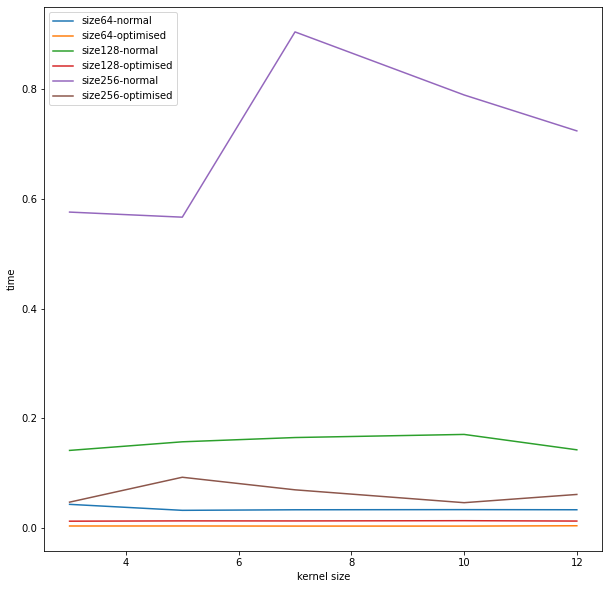

In [6]:
k=[3,5,7,10,12]
size=[64,128,256]
plt.figure(figsize=(10,10))
for s in size:
    t=[]
    ot=[]
    image=np.random.randint(256,size=(s,s))
    for i in k:
        start = time.time()
        averageFiltering(image,i)
        stop = time.time()
        t.append(stop-start)

        start = time.time()
        efficientAverageFiltering(image,i)
        stop = time.time()
        ot.append(stop-start)
    plt.plot(k,t,label="size"+str(s)+"-normal")
    plt.plot(k,ot,label="size"+str(s)+"-optimised")
plt.xlabel("kernel size")
plt.ylabel("time")
plt.legend()
plt.show()

## 1.3 
-  Runtimes for Optimal and Brute force are printed and we can observe the optimizitation. Also error is '0' between optimal and brute force

## Part IV - Efficient Median Filter 

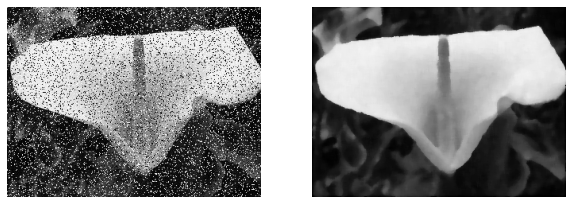

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def median(H,k):
    cs=np.cumsum(H)
    res=np.argmax(cs>k**2/2)
    return res

def MedianFilt(img,k):
    img = img.astype(np.float64)
    x = img.shape[0]
    y = img.shape[1]
    temp = np.zeros((x+k-1,y+k-1))
    kh = int(k/2)
    temp[kh:kh+x,kh:kh+y] = img[:,:]
    n_img = np.zeros((x,y))
    for i in range(kh,kh+x):
        for j in range(kh,kh+y):
            n_img[i-kh,j-kh] = np.median(temp[i-kh:i+kh+1,j-kh:j+kh+1])
    return n_img

def OptMedFilt(im,k):
    pad=int(k/2)
    res=np.zeros(im.shape)
    n_im=np.pad(im,((pad,pad),(pad,pad)),'constant')
    h=[]
    for i in range(int(n_im.shape[1])):
        hist=cv2.calcHist(np.array([n_im[0:k,i]]),[0],None,[256],[0,256]).reshape(1,256)[0]
        h.append(hist)
    H=np.zeros(256)
    for i in range(0,k):
        H+=h[i]
    for i in range(int(im.shape[0])):
        for j in range(int(im.shape[1])):
            if i==0 and j==0:
                res[i,j]=median(H,k)
            elif i!=0 and j==0:
                for l in range(0,k):
                    h[l][n_im[i-1,l]]-=1
                    h[l][n_im[i+k-1,l]]=h[l][n_im[i+k-1,l]]+1
                H=np.zeros(256)
                for m in range(k):
                    H+=h[m]
                res[i,j]=median(H,k)
            elif j!=0:
                if i==0:
                    H=H+h[j+k-1]-h[j-1]
                else:
                    h[j+k-1][n_im[i-1,j+k-1]]-=1
                    h[j+k-1][n_im[i+k-1,j+k-1]]+=1
                    H=H+h[j+k-1]-h[j-1]
                res[i,j]=median(H,k)
    return res

image = cv2.imread("../images/Noisy.jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

result=np.zeros(image.shape)

for i in range(3):
    result[:,:,i]=OptMedFilt(image[:,:,i],7)
plt.figure(figsize=(10,20))   
plt.subplot(1,2,1)
plt.imshow(image.astype(np.uint8))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result.astype(np.uint8))
plt.axis('off')
plt.show()

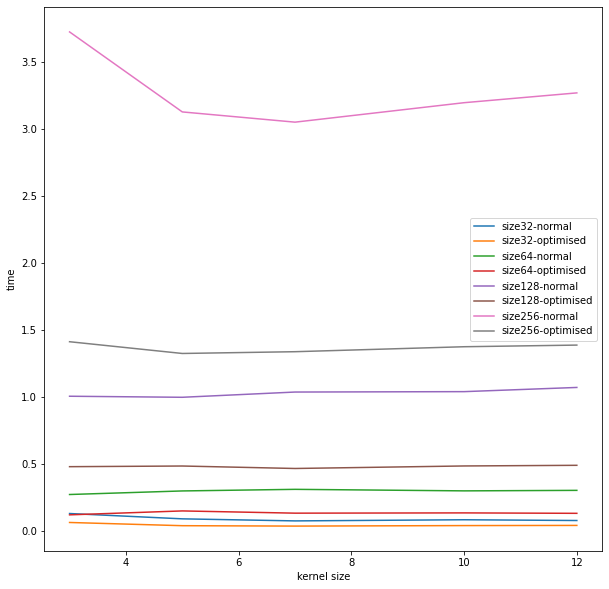

In [8]:
import timeit
k=[3,5,7,10,12]
size=[32,64,128,256]
plt.figure(figsize=(10,10))
for s in size:
    t=[]
    ot=[]
    image=np.random.randint(256,size=(s,s))
    image=image.astype(np.uint8)
    for i in k:
        start = timeit.default_timer()
        
        MedianFilt(image,i)
        stop = timeit.default_timer()
        t.append(stop-start)

        start = timeit.default_timer()
        OptMedFilt(image,i)
        stop = timeit.default_timer()
        ot.append(stop-start)
    plt.plot(k,t,label="size"+str(s)+"-normal")
    plt.plot(k,ot,label="size"+str(s)+"-optimised")
plt.xlabel("kernel size")
plt.ylabel("time")
plt.legend()





## 1.4 
- For the median the main concept is finding the middle pixel when the array is sorted.
- 1st implemented the same in brute force
    - **observation** : Here when we are sliding through a row or a column we need to subtract only the k elements and in bruteforce this is not possible best solution is *count sort* 
- In count sort at position (0,0)we will insert all the pixels into the 255 sized array and keep it aside and when we slided through a column we will use the same by removing the row at the top and adding the row in bottom so we can get the array every time in the order of k and for making cumulative sum we will take O(255) which is also constant. so it is best for higher values of k.


## 1.5 
- the noise is in the form of salt and pepper noise so median blurr will help to remove such noises the window size i used is 5